# An Accelerated Z16 Inference Service using Snap ML

A demonstration that shows how to accelerate an inferences service by leveraging the Snap ML library and the Z16 AI Accelerator.

## Elliptic (Bitcoin Transactions) Workload

In this demo, we wil use the Elliptic dataset released on Kaggle in 2019 (https://www.kaggle.com/datasets/ellipticco/elliptic-data-set). This dataset is a sub-graph of a bitcoin graph, made of 203,769 nodes and 234,355 edges. Together with the graph information, it also categorizes the nodes into three classes: “licit”, “illicit” or “unkown”. A node is deemed "licit" / "illicit" if the corresponding transaction has been created by an entity that belongs to a licit (exchanges, wallet providers, miners, financial service providers, etc.) or illicit (scams, malware, ransomware, Ponzi schemes, etc.) category respectively.

We will use machine learning (ML) to classify the nodes as licit or illicit, given a set of features and the graph topology. Since not all the nodes are labeled, in this demo we will filter out the unlabeled nodes and model the problem using supervised learning. As a ML model we will use a random forest classifier (a widely-used model for tabular data). Each row in the dataset represents a Bitcoin transaction, labeled as "licit" or "illicit".

We will split the dataset into train and test sets. We will train a Sklearn Random Forest classifier using the Elliptic train dataset. In this demo, we will import that pre-trained model into the Snap ML library and use the Snap ML prediction engine to classify Bitcoin transactions (extracted from the test dataset). For performance comparison, we will perform a similar experiment using Sklearn, namely we will load the pre-trained Sklearn model into Sklearn and use the Sklearn prediction engine for transaction classification.

The prediction engines will run on a chip with 6 dedicated cores and 1 AI accelerator. The Snap ML prediction engine will use the AI accelerator, while the Sklearn engine will use the CPU.  

In [41]:
# to install snapml uncomment the line below
!pip install snapml
!pip install onnxmltools

In [42]:
# import the ML models from sklearn and Snap ML
from snapml import RandomForestClassifier as snapRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier as sklearnRandomForestClassifier

# import sklearn utils and metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

# import onnx tools
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType

from project_lib import Project
project = Project()

## Data Analysis / Preprocessing

In [43]:
# data preprocessing based on the code available here 
# https://www.kaggle.com/code/smlopezza/elliptic-data-set-eda-graphs-random-forest



classes_file = project.get_file('elliptic_txs_classes.csv')
df_classes = pd.read_csv(classes_file)


edges_file = project.get_file('elliptic_txs_edgelist.csv')
df_edges = pd.read_csv(edges_file)


features_file = project.get_file('elliptic_txs_features.csv')
df_features = pd.read_csv(features_file,header=None)


# download the Kaggle dataset to your local folder and change the prefix_folder accordingly
#prefix_folder = "/root/z-snap-demo/hey-experiments/bentoml-0.13.1/bitcoin/data/elliptic_bitcoin_dataset/"

#df_classes = pd.read_csv(prefix_folder + "elliptic_txs_classes.csv")
#df_edges = pd.read_csv(prefix_folder + "elliptic_txs_edgelist.csv")
#df_features = pd.read_csv(prefix_folder + "elliptic_txs_features.csv", header=None)

# rename the feature names
colNames1 = {'0': 'txId', 1: "Time step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}
colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}
df_features = df_features.rename(columns=colNames)

# rename the unknown class of transactions to 3
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = str(3)

df_class_feature = pd.merge(df_classes, df_features )
df_class_feature.head()

,txId,class,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,3,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,3,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,3,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,3,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [45]:
# filter out the unknown transactions - in a supervised learning approch, we need a labeled dataset
group_class_feature = df_class_feature.groupby(['class']).count()
group_class_feature = group_class_feature['txId'].reset_index().rename(columns={'txId': 'count'})

selected_ids = df_class_feature.loc[(df_class_feature['class'] != '3'), 'txId']
df_edges_selected = df_edges.loc[df_edges['txId1'].isin(selected_ids)]
df_classes_selected = df_classes.loc[df_classes['txId'].isin(selected_ids)]
df_features_selected = df_features.loc[df_features['txId'].isin(selected_ids)]

# merge class and features
df_class_feature_selected = pd.merge(df_classes_selected, df_features_selected )
df_class_feature_selected.head()
print("Dataset info used for training and inference: ", df_class_feature_selected.shape)

Dataset info used for training and inference:  (46564, 168)


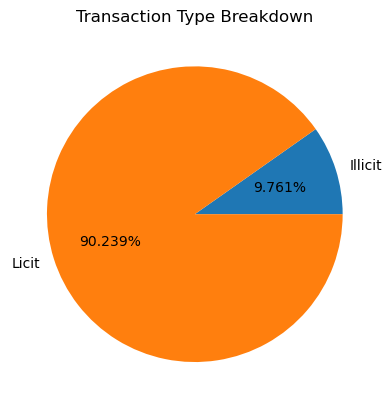

In [46]:
group_class_feature_selected = df_class_feature_selected.groupby(['class']).count()
group_class_feature_selected = group_class_feature_selected['txId'].reset_index().rename(columns={'txId': 'count'})

# get the set of distinct classes and rename the unique classes
labels = group_class_feature_selected['class'].unique()
labels[labels=='2'] = 'Licit'
labels[labels=='1'] = 'Illicit'

# get the count of each class
sizes = group_class_feature_selected['count'].values

# plot the class value % counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Transaction Type Breakdown')
plt.show()

In [47]:
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

# drop class, text id and timestamp from the feature matrix
X = df_class_feature_selected.drop(columns=['txId', 'class', 'Time step'])
y = df_class_feature_selected[['class']]

# encode the labels 0: licit transaction and 2: illicit transaction
y = y['class'].apply(lambda x: 0 if x == '2' else 1 )

# split the dataset into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

np.save("X_train.npy", X_train) # 35K, 165
np.save("y_train.npy", y_train) # 35K, 
np.save("X_test.npy", X_test)   # 11K, 165
np.save("y_test.npy", y_test)   # 11K



print("X_train.shape ", X_train.shape)
print("X_test.shape ",  X_test.shape)

X_train.shape  (34923, 165)
X_test.shape  (11641, 165)


## Train an Ensemble Model Classifier (Anywhere) and Save it as ONNX

In [48]:
import pickle
# train a sklearn RF model using the elliptic train dataset
#folder_prefix = "/root/z-snap-demo/hey-experiments/bentoml-0.13.1/bitcoin/data/elliptic_bitcoin_dataset/"

X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")

# train a scikit-learn Random Forest Classifier model
model = sklearnRandomForestClassifier(n_estimators = 1000, max_depth=5, n_jobs=4, random_state=42)
t0 = time.time()
model.fit(X_train, y_train)
t1 = time.time()
print("Model training time %.4f [s]" % (t1-t0))

# save it as a pkl file for later model import into the native Sklearn inference runtime
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)
    
initial_type = [("float_input", FloatTensorType([None, X_train.shape[1]]))]
onnx_model = onnxmltools.convert_sklearn(model, initial_types=initial_type)

# save it as an onnx file for later model import into the Snap ML inference runtime
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
    
print("Model training finished...")

Model training time 15.5408 [s]
Model training finished...


# Import Pre-trained Model for the Inference Service using Snap ML

In [49]:
folder_prefix = "/root/z-snap-demo/hey-experiments/bentoml-0.13.1/bitcoin/data/elliptic_bitcoin_dataset/"

# load model and predict with snapml using the test dataset
X_test = np.load("X_test.npy")
y_test = np.load( "y_test.npy")

snapml_model = snapRandomForestClassifier()

# to tune the number of CPU threads used at inference time use the line below
snapml_model.set_params(n_jobs=12)

# Import ONNX model into Snap ML. The inference will run on the AI accelerator as indicate by the zdnn_tensors flag
snapml_model.import_model("model.onnx", "onnx", "zdnn_tensors")

batch_size = 128
batch_count = 100
np.random.seed(536389674)

snapml_predict_time = 0
transactions_indices = np.array([])
predictions = np.array([])

# run inference on batch_count batches of size batch_size each
for i in range(batch_count):
    batch_indices = np.random.randint(0, X_test.shape[0], size=batch_size)
    transactions_indices = np.append(transactions_indices, batch_indices)
    batch = X_test[batch_indices]
    t0 = time.time()
    preds = snapml_model.predict(batch)
    t1 = time.time()
    predictions = np.append(predictions, preds)
    snapml_predict_time += t1 - t0
print("[Snap ML model] Average inference time per batch %.4f [ms]" % (snapml_predict_time/batch_count))

prec, rec, f1, num = precision_recall_fscore_support(y_test[transactions_indices.astype(int)], predictions)
print("[Snap ML model] Precision:%.3f Recall:%.3f F1 Score:%.3f " % (prec[1],rec[1],f1[1]))

[Snap ML model] Average inference time per batch 0.0034 [ms]
[Snap ML model] Precision:0.987 Recall:0.758 F1 Score:0.857 


# Import Pre-trained Model for the Inference Service using Sklearn

In [50]:
folder_prefix = "/root/z-snap-demo/hey-experiments/bentoml-0.13.1/bitcoin/data/elliptic_bitcoin_dataset/"

# load model and predict with snapml using the test dataset
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

sk_model = sklearnRandomForestClassifier()
with open("model.pkl", "rb") as f:
    sk_model = pickle.load(f)

# to tune the number of CPU threads used at inference time use the commented line below
sk_model.set_params(n_jobs=12)

batch_size = 128
batch_count = 100
np.random.seed(536389674)

sklearn_predict_time = 0
transactions_indices = np.array([])
predictions = np.array([])

# run inference on batch_count batches of size batch_size each
for i in range(batch_count):
    batch_indices = np.random.randint(0, X_test.shape[0], size=batch_size)
    transactions_indices = np.append(transactions_indices, batch_indices)
    batch = X_test[batch_indices]
    t0 = time.time()
    preds = sk_model.predict(batch)
    t1 = time.time()
    predictions = np.append(predictions, preds)
    sklearn_predict_time += t1 - t0
print("[Sklearn model] Average inference time per batch %.4f [ms]" % (sklearn_predict_time/batch_count))

prec, rec, f1, num = precision_recall_fscore_support(y_test[transactions_indices.astype(int)], predictions)
print("[Sklearn model] Precision:%.3f Recall:%.3f F1 Score:%.3f " % (prec[1],rec[1],f1[1]))

[Sklearn model] Average inference time per batch 0.1197 [ms]
[Sklearn model] Precision:0.987 Recall:0.758 F1 Score:0.857 


In [51]:
print("Snap ML vs Sklearn inference speedup ", sklearn_predict_time/snapml_predict_time)

Snap ML vs Sklearn inference speedup  34.97462595938649
